In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization


In [18]:
sns.set(style='white', context='notebook', palette='deep')

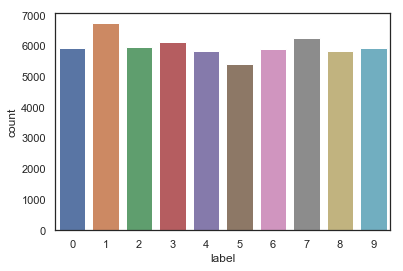

In [19]:
X_train = pd.read_csv('./mnist_train.csv')
X_test = pd.read_csv('./mnist_test.csv')
y_train = X_train['label']
X_train = X_train.drop(labels=['label'], axis=1)
g = sns.countplot(y_train)

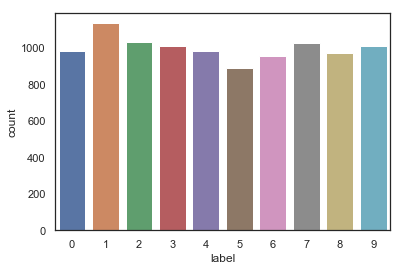

In [20]:
y_test = X_test['label']
X_test = X_test.drop(labels=['label'], axis=1)
g = sns.countplot(y_test)

In [21]:
y_train.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

In [22]:
y_test.value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

In [23]:
#check for null and missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [24]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

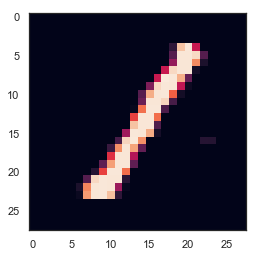

In [25]:
#Normalization
X_train = X_train / 255
X_test = X_test / 255

#Reshape
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

#Encode labels to one hot vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#split training and validation set for the fitting
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.1,
                                                 random_state=random_seed)
g = plt.imshow(X_train[777][:,:,0])

In [26]:
#CNN model
model = Sequential()


In [27]:
model.add(Conv2D(32,(5,5), padding='same',
                 activation='relu', input_shape =(28,28,1)))
model.add(Conv2D(32,(5,5), padding='same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), padding='same',
                activation='relu'))
model.add(Conv2D(64,(3,3), padding='same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [28]:
#set optimizer and annealer
optimizer = Adam(epsilon=1e-08)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
             metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [29]:
epochs = 20
batch_size = 128


In [30]:
#data augmentation
datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2)
datagen.fit(X_train)

In [31]:
history = model.fit_generator(datagen.flow(x = X_train, y = y_train, batch_size = batch_size),
                   epochs = epochs, validation_data = (X_val, y_val),
                   verbose = 2, 
                   steps_per_epoch = X_train.shape[0] // batch_size,
                   callbacks=[learning_rate_reduction])

Epoch 1/20
 - 228s - loss: 0.5349 - acc: 0.8327 - val_loss: 2.8022 - val_acc: 0.1487
Epoch 2/20
 - 231s - loss: 0.1581 - acc: 0.9536 - val_loss: 2.7433 - val_acc: 0.1335
Epoch 3/20
 - 230s - loss: 0.1213 - acc: 0.9638 - val_loss: 5.0645 - val_acc: 0.0983
Epoch 4/20
 - 246s - loss: 0.1054 - acc: 0.9671 - val_loss: 4.1028 - val_acc: 0.0983

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
 - 243s - loss: 0.0803 - acc: 0.9766 - val_loss: 4.0306 - val_acc: 0.0985
Epoch 6/20
 - 247s - loss: 0.0708 - acc: 0.9789 - val_loss: 4.8794 - val_acc: 0.0983
Epoch 7/20
 - 254s - loss: 0.0678 - acc: 0.9796 - val_loss: 4.8380 - val_acc: 0.0983

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/20
 - 255s - loss: 0.0574 - acc: 0.9822 - val_loss: 5.2476 - val_acc: 0.0983
Epoch 9/20
 - 265s - loss: 0.0568 - acc: 0.9833 - val_loss: 6.3650 - val_acc: 0.0983
Epoch 10/20
 - 255s - loss: 0.0555 - acc: 0.9831 - val_loss: 6.7923 - val